In [ ]:
%matplotlib inline

In [ ]:
!pip install livelossplot

You should consider upgrading via the 'C:\Users\thari\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
# Imports
import numpy as np
import pandas as pd
from glob import glob
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sn

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, GlobalMaxPooling2D, Input, Concatenate, LSTM, SimpleRNN, Conv2D, MaxPooling2D, Reshape
from keras.models import Model, Sequential
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3

from livelossplot import PlotLossesKeras

In [ ]:
# Output files
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_FILE = "histopathologic_cancer_detector.h5"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
ROC_PLOT_FILE = "roc.png"
MODEL_LAYERS_SIMPLIFIED = "model_plot_simplified.png"
MODEL_LAYERS = "model_plot.png"
INPUT_DIR = '../input/histopathologic-cancer-detection/'
training_path = '../training'
validation_path = '../validation'

In [ ]:
# Hyperparams
SAMPLE_COUNT = 85000
TRAINING_RATIO = 0.9
IMAGE_SIZE = 96
EPOCHS = 16
BATCH_SIZE = 216
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

In [ ]:
# Data setup
training_dir = INPUT_DIR + 'train/'
data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})
data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[4].split('.')[0])
labels = pd.read_csv(INPUT_DIR + 'train_labels.csv')
data_frame = data_frame.merge(labels, on = 'id')
negatives = data_frame[data_frame.label == 0].sample(SAMPLE_COUNT)
positives = data_frame[data_frame.label == 1].sample(SAMPLE_COUNT)
data_frame = pd.concat([negatives, positives]).reset_index()
data_frame = data_frame[['path', 'id', 'label']]

In [ ]:
for folder in [training_path, validation_path]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        os.makedirs(path, exist_ok=True)

training, validation = train_test_split(data_frame, train_size=TRAINING_RATIO, stratify=data_frame['label'])

data_frame.set_index('id', inplace=True)

for images_and_path in [(training, training_path), (validation, validation_path)]:
    images = images_and_path[0]
    path = images_and_path[1]
    for image in images['id'].values:
        file_name = image + '.tif'
        label = str(data_frame.loc[image,'label'])
        destination = os.path.join(path, label, file_name)
        if not os.path.exists(destination):
            source = os.path.join(INPUT_DIR + 'train', file_name)
            shutil.copyfile(source, destination)

In [ ]:
# Data generation
training_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=90,
                                             zoom_range=0.2,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             shear_range=0.05,
                                             channel_shift_range=0.1).flow_from_directory(training_path,
                                                                                          target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                                          batch_size=BATCH_SIZE,
                                                                                          class_mode='binary')
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                              target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                              batch_size=BATCH_SIZE,
                                                                              class_mode='binary')

Found 153000 images belonging to 2 classes.
Found 17000 images belonging to 2 classes.


In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
model = Sequential()
model.add(Input(input_shape))
model.add(InceptionV3(include_top=False, input_shape=input_shape))
model.add(GlobalMaxPooling2D())
model.add(Reshape((1, -1)))
# model.add(LSTM(256,return_sequences=True))
model.add(LSTM(128))
# model.add(SimpleRNN(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001, decay=0.0001,beta_1=0.9,epsilon=1.0),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 reshape (Reshape)           (None, 1, 2048)           0         
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

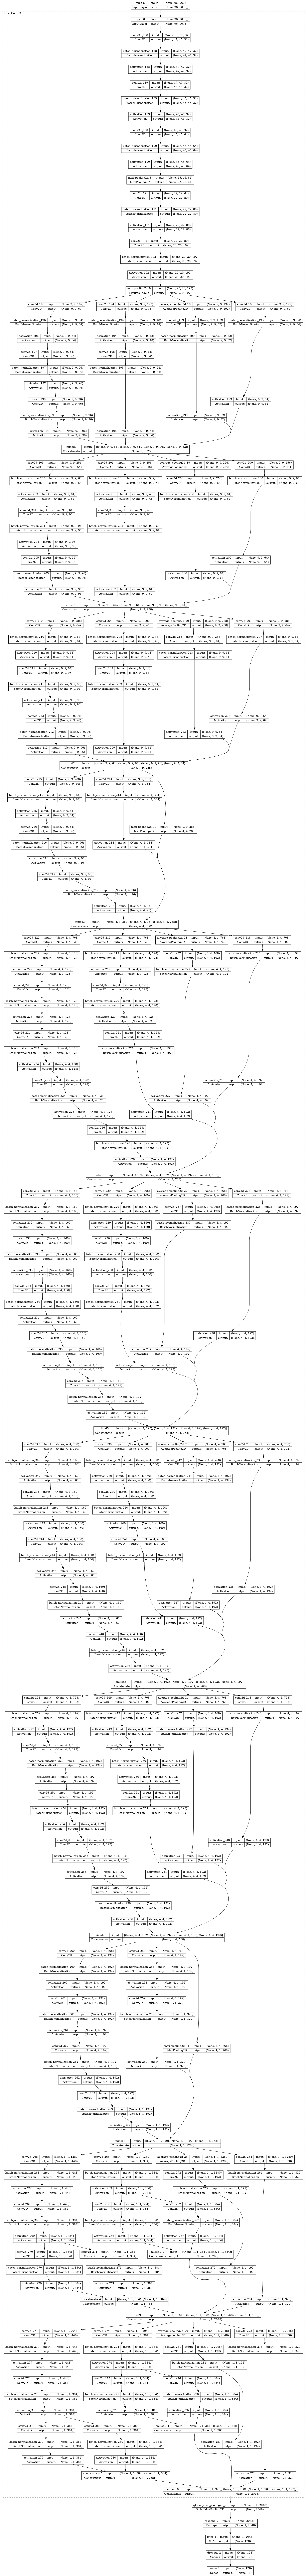

In [ ]:
# Plot the model layer and save it as a file
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

from keras.utils.vis_utils import plot_model
plot_model(model, to_file=MODEL_LAYERS_SIMPLIFIED, show_shapes=True, show_layer_names=True, expand_nested=False)
plot_model(model, to_file=MODEL_LAYERS, show_shapes=True, show_layer_names=True, expand_nested=True)

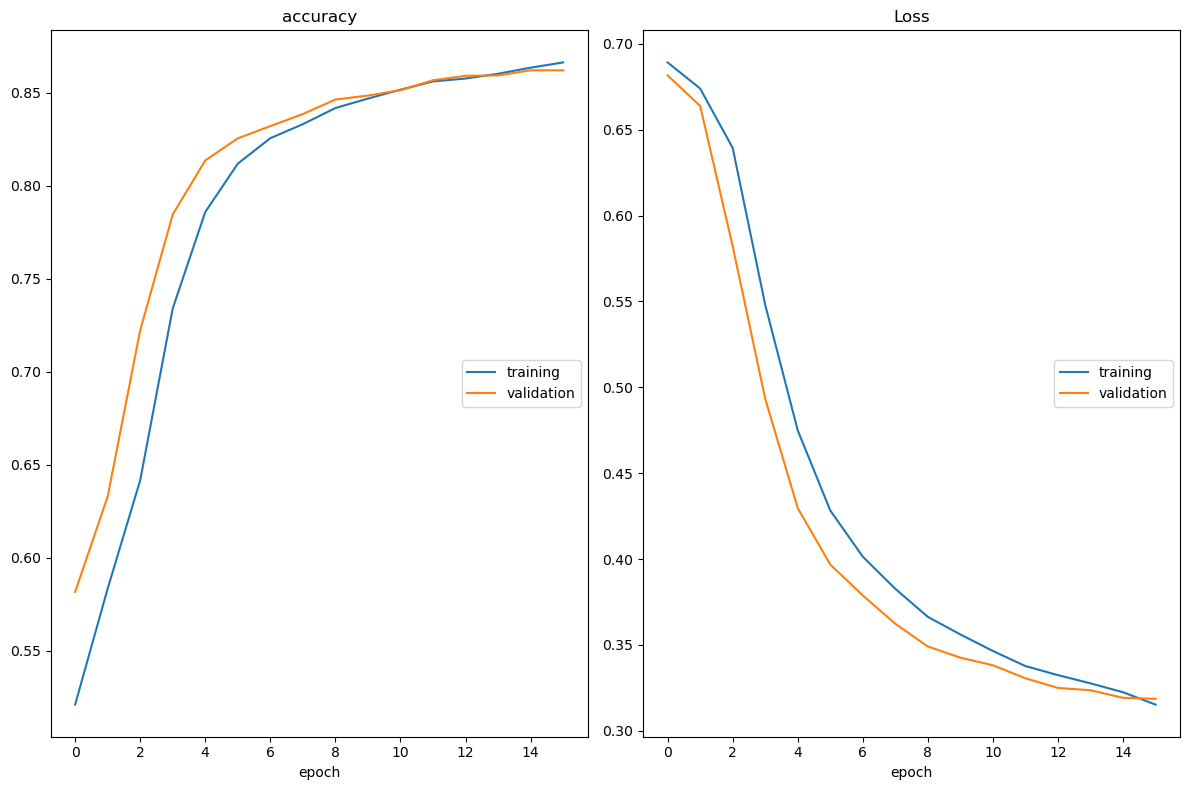

accuracy
	training         	 (min:    0.521, max:    0.866, cur:    0.866)
	validation       	 (min:    0.582, max:    0.862, cur:    0.862)
Loss
	training         	 (min:    0.315, max:    0.689, cur:    0.315)
	validation       	 (min:    0.319, max:    0.682, cur:    0.319)

Epoch 16: val_accuracy did not improve from 0.86212
709/709 [==============================] - 528s 744ms/step - loss: 0.3153 - accuracy: 0.8664 - val_loss: 0.3186 - val_accuracy: 0.8621


In [ ]:
# fit the model on data generator
history = model.fit(training_generator,
          steps_per_epoch=len(training_generator),
          validation_data=validation_generator,
          validation_steps=len(validation_generator),
          epochs=EPOCHS,
          verbose=VERBOSITY,
          callbacks=[PlotLossesKeras(),
                     ModelCheckpoint(MODEL_FILE,
                                     monitor='val_accuracy',
                                     verbose=VERBOSITY,
                                     save_best_only=True,
                                     mode='max'),
                     CSVLogger(TRAINING_LOGS_FILE,
                               append=False,
                               separator=',')
                    ])

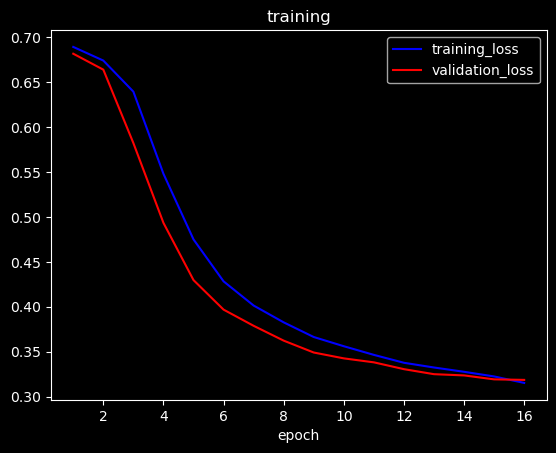

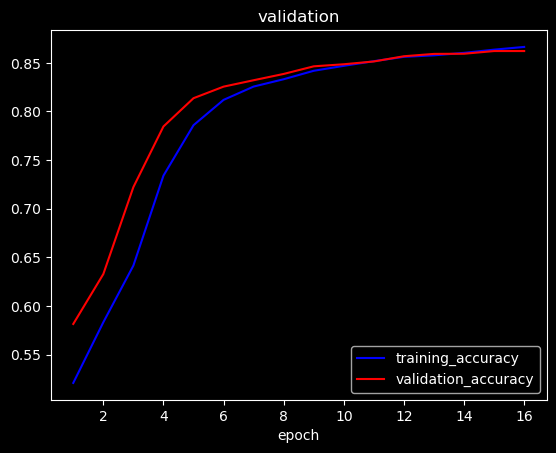

In [ ]:
# Training plots
epochs = [i for i in range(1, len(history.history['loss'])+1)]
plt.style.use('dark_background')

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.savefig(TRAINING_PLOT_FILE, bbox_inches='tight')
plt.show()

plt.plot(epochs, history.history['accuracy'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_accuracy'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.savefig(VALIDATION_PLOT_FILE, bbox_inches='tight')
plt.show()

In [ ]:
model.load_weights(MODEL_FILE)

In [ ]:
roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                                  target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                                  batch_size=BATCH_SIZE,
                                                                                  class_mode='binary',
                                                                                  shuffle=False)
# roc_valid_gen = custom_generator(roc_validation_generator)
predictions = model.predict(roc_validation_generator, steps=len(roc_validation_generator), verbose=VERBOSITY)

Found 17000 images belonging to 2 classes.
79/79 [==============================] - 23s 292ms/step


Found 17000 images belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


79/79 [==============================] - 19s 218ms/step


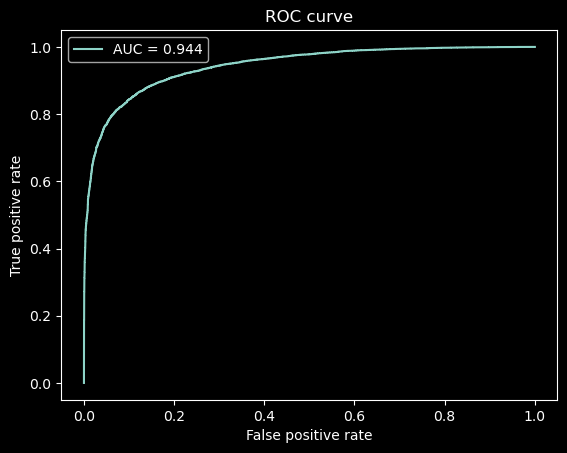

In [ ]:
roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                                  target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                                  batch_size=BATCH_SIZE,
                                                                                  class_mode='binary',
                                                                                  shuffle=False)
# roc_valid_gen = custom_generator(roc_validation_generator)
predictions = model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=VERBOSITY)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()

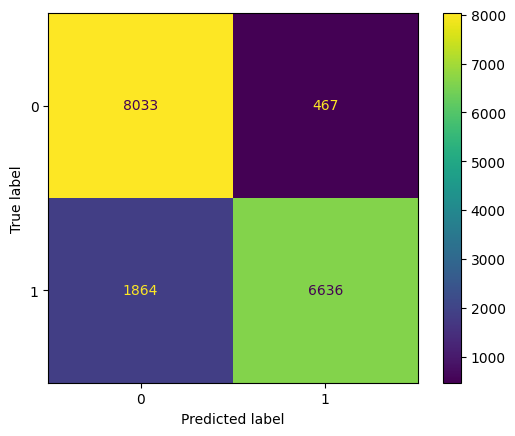

In [ ]:
y_act = roc_validation_generator.classes
y_pred = [1 if i > 0.5 else 0 for i in predictions]
class_labels = list(roc_validation_generator.class_indices.keys())
cm=confusion_matrix(y_true=y_act, y_pred=y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

<Axes: >

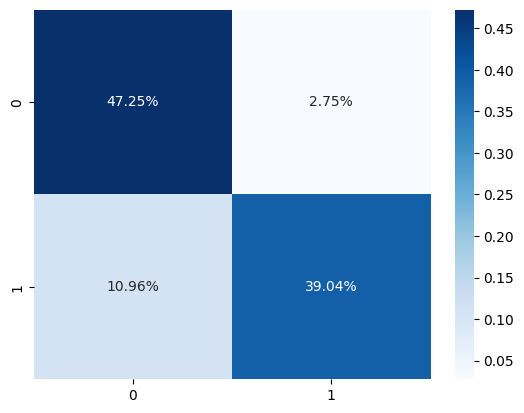

In [ ]:
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
print(classification_report(y_act, y_pred,target_names=class_labels))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      8500
           1       0.93      0.78      0.85      8500

    accuracy                           0.86     17000
   macro avg       0.87      0.86      0.86     17000
weighted avg       0.87      0.86      0.86     17000



<AxesSubplot:>

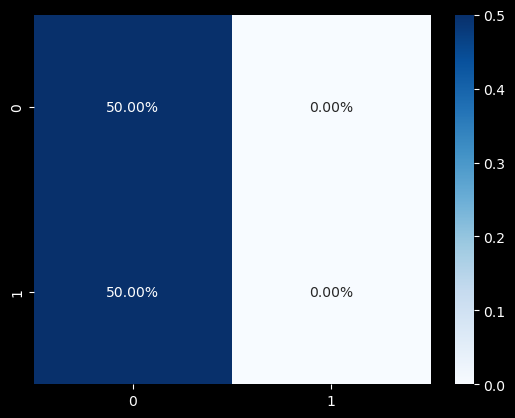

In [ ]:
sn.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues')

In [ ]:
!zip -r data.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/model_plot.png (deflated 16%)
  adding: kaggle/working/training.png (deflated 9%)
  adding: kaggle/working/roc.png (deflated 9%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/validation.png (deflated 9%)
  adding: kaggle/working/training_logs.csv (deflated 50%)
  adding: kaggle/working/model_plot_simplified.png (deflated 13%)
  adding: kaggle/working/histopathologic_cancer_detector.h5 (deflated 24%)
  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)


In [ ]:
import os
os.chdir(r'/kaggle/working')
print(os.listdir())
from IPython.display import FileLink
FileLink(r'data.zip')
# FileLink(TRAINING_LOGS_FILE)
# FileLink(MODEL_FILE)
# FileLink(TRAINING_PLOT_FILE)
# FileLink(VALIDATION_PLOT_FILE)
# FileLink(ROC_PLOT_FILE)

['model_plot.png', 'training.png', 'roc.png', '.virtual_documents', 'validation.png', 'training_logs.csv', 'model_plot_simplified.png', 'histopathologic_cancer_detector.h5', '__notebook_source__.ipynb', 'data.zip']


/kaggle/working/data.zip